In [46]:
import pandas as pd
from glob import glob

# Read Data

In [3]:
paths = './data/311/*.csv'

In [4]:
glob(paths)

['./data/311/2018-06.csv',
 './data/311/2018-12.csv',
 './data/311/2018-07.csv',
 './data/311/2018-11.csv',
 './data/311/2018-05.csv',
 './data/311/2018-04.csv',
 './data/311/2018-10.csv',
 './data/311/2018-01.csv',
 './data/311/2018-03.csv',
 './data/311/2018-02.csv',
 './data/311/2018-09.csv',
 './data/311/2018-08.csv']

In [5]:
data = pd.concat([pd.read_csv(p, low_memory=False, index_col=0) for p in glob(paths)])

/anaconda3/envs/packt/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
data.columns

Index(['address_type', 'agency', 'agency_name', 'bbl', 'borough',
       'bridge_highway_direction', 'bridge_highway_name',
       'bridge_highway_segment', 'city', 'closed_date', 'community_board',
       'complaint_type', 'created_date', 'cross_street_1', 'cross_street_2',
       'descriptor', 'due_date', 'facility_type', 'incident_address',
       'incident_zip', 'intersection_street_1', 'intersection_street_2',
       'landmark', 'latitude', 'location', 'location_type', 'longitude',
       'open_data_channel_type', 'park_borough', 'park_facility_name',
       'resolution_action_updated_date', 'resolution_description', 'road_ramp',
       'status', 'street_name', 'taxi_company_borough',
       'taxi_pick_up_location', 'unique_key', 'vehicle_type',
       'x_coordinate_state_plane', 'y_coordinate_state_plane'],
      dtype='object')

In [7]:
data.shape

(2747985, 41)

# Density

In [ ]:
from datashader.colors import 

In [54]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import inferno

In [55]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)

In [56]:
agg = cvs.points(data, 'x_coordinate_state_plane', 'y_coordinate_state_plane',  ds.count())

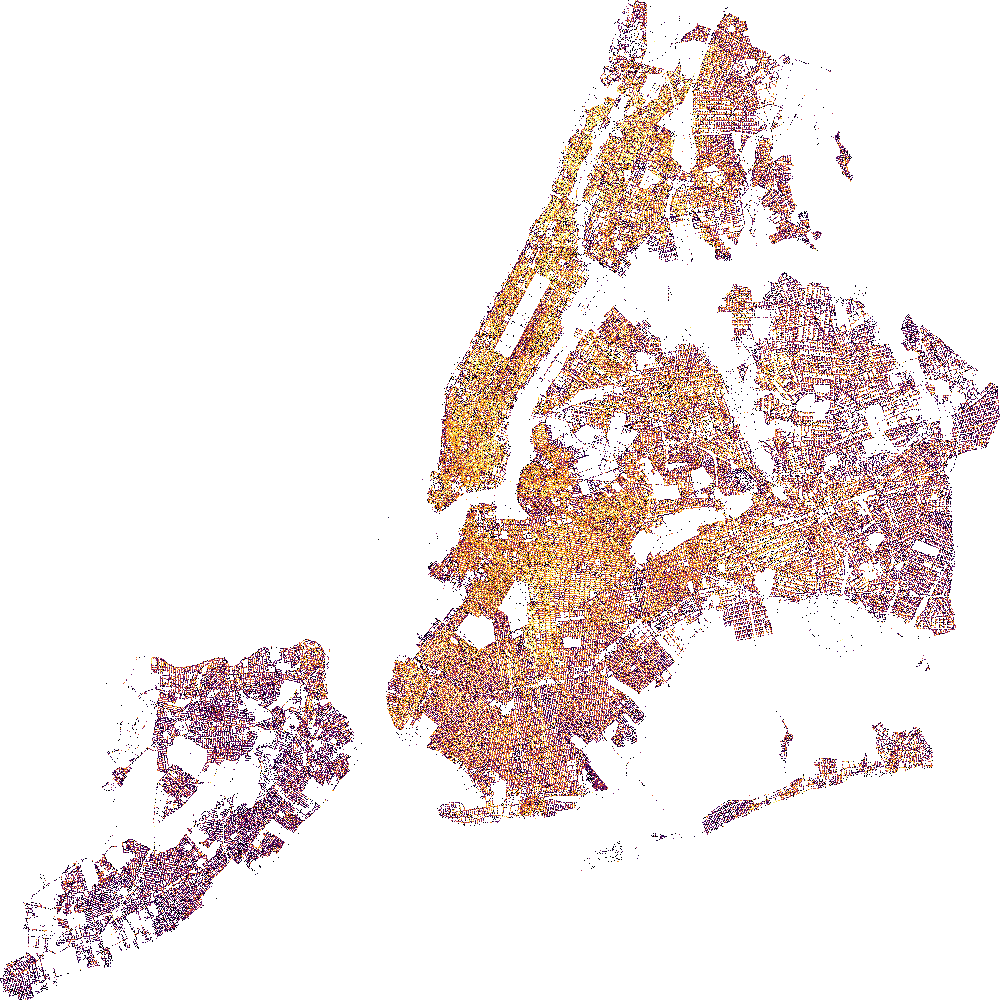

In [57]:
tf.shade(agg, cmap=inferno, how='eq_hist')

# Complaint Source

In [25]:
data['open_data_channel_type'].value_counts()

PHONE      1469034
ONLINE      565348
UNKNOWN     366890
MOBILE      314247
OTHER        32466
Name: open_data_channel_type, dtype: int64

In [26]:
colors = {'PHONE':'red',
 'ONLINE':'blue',
 'UNKNOWN':'grey',
 'MOBILE':'green',
 'OTHER': 'brown'}

In [27]:
data['open_data_channel_type'] = data['open_data_channel_type'].astype('category')

In [28]:
agg_cat = cvs.points(data, 'x_coordinate_state_plane', 'y_coordinate_state_plane',
                     ds.count_cat('open_data_channel_type'))

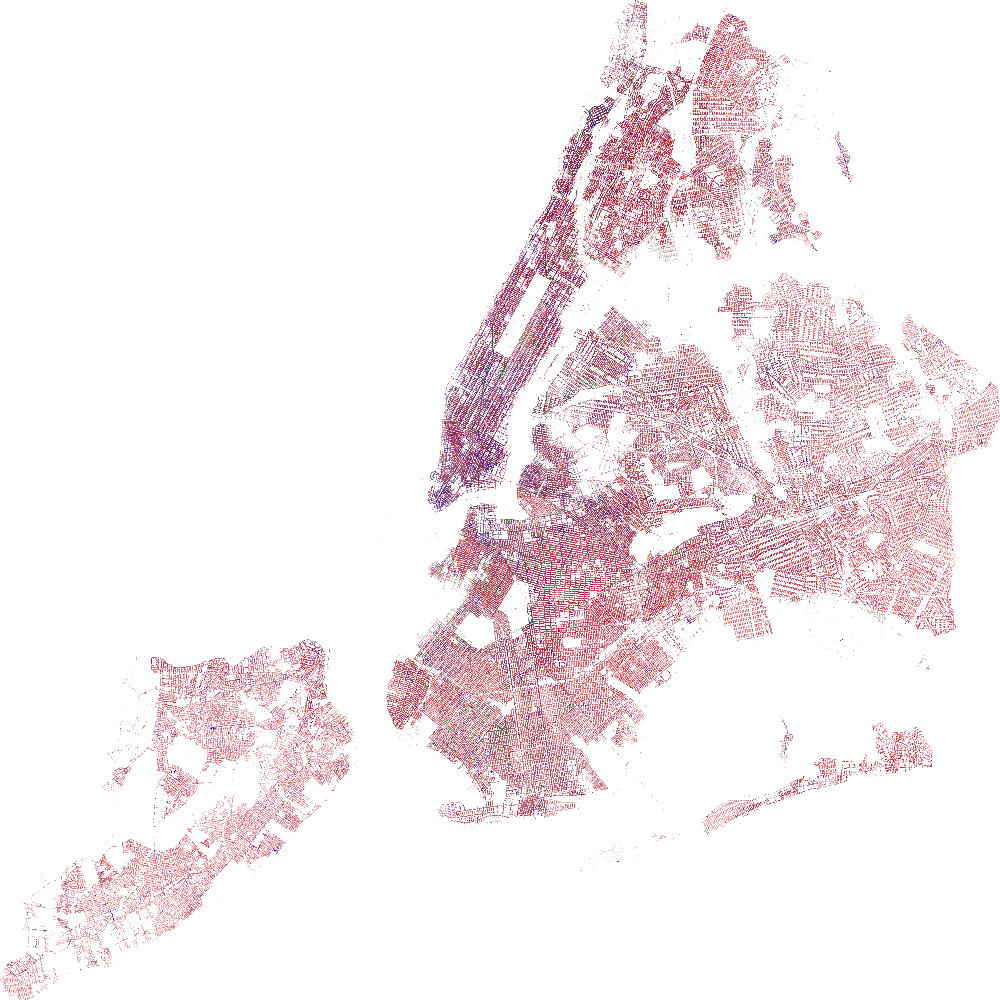

In [29]:
  t

# Time to close

In [30]:
data['created_date'] = pd.to_datetime(data['created_date'])
data['time_of_day'] = data['created_date'].dt.hour * 60 + data['created_date'].dt.minute
data['doy'] = data['created_date'].dt.dayofyear
data['month'] = data['created_date'].dt.month

In [31]:
data['closed_date'] = pd.to_datetime(data['closed_date'])

In [32]:
data['time_to_close'] = (data['closed_date'] - data['created_date']).dt.seconds

In [37]:
agg_time = cvs.points(data, 'x_coordinate_state_plane', 'y_coordinate_state_plane', ds.mean('time_to_close'))

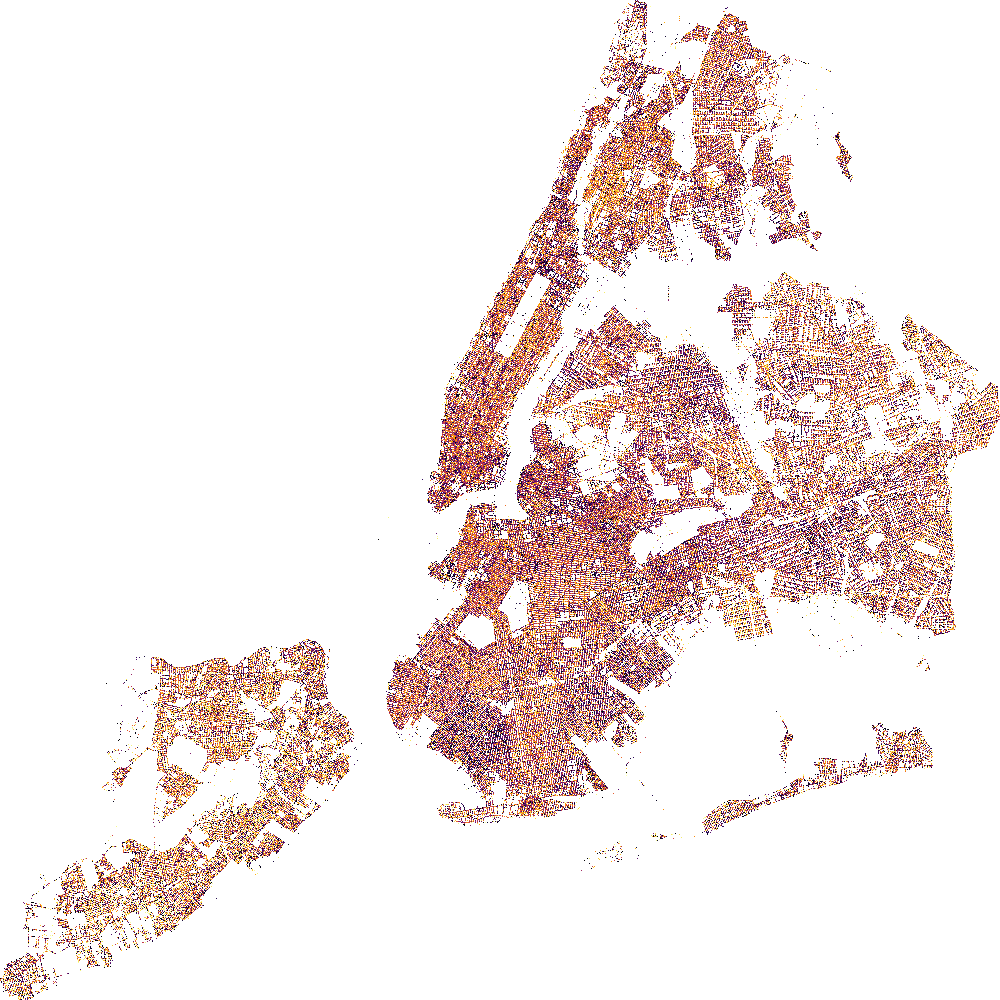

In [45]:
tf.shade(agg_time, cmap=inferno, how='eq_hist')